In [3]:
import ast
import binascii
import gzip
import io
import json
import nilearn
import os
import pathlib
import tarfile
import zipfile

from collections import Counter
from io import BytesIO
from io import StringIO
from nilearn.connectome import ConnectivityMeasure
from nilearn.input_data import NiftiMapsMasker
from nilearn import plotting
from nilearn.plotting import plot_anat
from nilearn.plotting import find_probabilistic_atlas_cut_coords as find_cut_coords
from os import listdir as ls
from os.path import basename as bname
from os.path import dirname as dname
from os.path import expanduser as xpu
from os.path import join as pjoin

import nibabel as nib
import numpy as np
import pandas as pd
from pandas import DataFrame as df
from pathlib import Path

import loadutils as lu
# import scanzip

datalad_config_path = Path(xpu('~/../../data/cisl/DATA/cimaq_20190901/.datalad/config'))
cimaq_path = xpu('~/../../data/cisl/DATA/cimaq_20190901')
env_packages = xpu('~/py369env/bin')

stlaurent_path = xpu('~/../../data/neuromod/DATA/CIMAQ_fmri_memory')
conf_path = pjoin(stlaurent_path, 'data/confounds/resample')


In [70]:
cimaq_scan_parameters = {"localizer_12-Channel": [],
                         "MPRAGE_ipat2": [],
                         "Axial_T2-FLAIR_iPAT2": [],
                         "PD_T2_1sequence": [],
                         "AXIAL_T2_STAR_iPAT2": [],
                         "DWI": ["DWI-B02", "DWI-B03"],
                         "fmri": ["MemoryTask",
                                  "MemoryTask_AP",
                                  "fieldmap_gre_field_mapping",
                                  "MemoryTask_PA",
                                  "BOLD Resting State"]}
cimaq_scan_parameters = ast.literal_eval(str(cimaq_scan_parameters).replace('_', ' '))
params_text = list(cimaq_scan_parameters.keys())+cimaq_scan_parameters['fmri']


In [62]:
tarfile_contents = pd.read_csv('~/cimaq_memory/tarfile_contents.tsv',
                               sep = '\t').set_index(
                                   'Unnamed: 0').reset_index(drop = True)


tarfile_contents['split_basenames'] = [ast.literal_eval(row[1].split_basenames)
                                       if 'CIMAQ' not in row[1].split_basenames
                                       else {'dates': \
                                             row[1].basenames.split('_')[1],
                                             'archv_names': \
                                             '_'.join(row[1].basenames.split('_')[2:])}
                                       for row in tarfile_contents.iterrows()]

tarfile_contents = pd.concat([tarfile_contents,
                              df(tarfile_contents['split_basenames'].values.tolist())],
                             axis = 1)

# Saving
# tarfile_contents.to_csv('~/cimaq_memory/tarfile_contents.tsv',
#                         sep = '\t', encoding = 'UTF-8')

# tarfile_contents['inner_contents'] = \
#     [df.from_dict(mytar.getmember(row[1].names).get_info(),
#                   orient = 'index').T.squeeze()
#      for row in tarfile_contents.iterrows()]

series_uids_pscid = pd.read_csv('series_uids_pscid.tsv',
                                sep = '\t').set_index(
                        'Unnamed: 0').reset_index(drop = True)
series_uids_pscid = series_uids_pscid.rename(columns = {'0': 'sub_id',
                                                        '1': 'series'})
# ast.literal_eval(series_uids_pscid.iloc[0].series)
# key example ["('3002498', '327986')"] or ["('3025432', '658178')"]
vals = df(dict(tuple(('_'.join(itm[0]),
               df(itm[1].splitlines()))
              for itm in
              series_uids_pscid.values.tolist(
              ))).values()).values.tolist()
subids = ['_'.join([itm.strip() for itm in
                    itm.replace('(','').replace(
                        ')','').replace("'", '').split(',')])
          for itm in series_uids_pscid.sub_id.values.tolist()]

test = df.from_dict(dict(tuple(zip(subids, vals))),
             orient = 'index')
archive_distrib = dict(tuple(zip(subids,
                                 [itm[0][1:].values for itm
                                  in test[0].values.tolist()])))
# Saving
# test.to_csv('~/cimaq_memory/series_uids_pscid_ordered.tsv',
#                                       sep = '\t', encoding = 'UTF-8')

In [98]:
archive_distrib_dccid = dict(tuple(zip([akey.split('_')[1] for akey in
                                        list(archive_distrib.keys())],
                                       list(archive_distrib.values()))))

archive_distrib_dccid

{'327986': array(['2245   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
        '2246   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
        '2247   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
        '2248   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
        '2249   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
        '2250   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
        '2251   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
        '2252   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
        '2253   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
        '2254   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
        '2255   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
        '2256   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
        '2257   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
        '2258   V10  DCM_2017-05-15_ImagingUpload-12-5

In [117]:
series_uids_pscid.series.values.tolist()[0].splitlines()
# tarfile_contents
# subs
# confs

['2245   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
 '2246   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
 '2247   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
 '2248   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
 '2249   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
 '2250   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
 '2251   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
 '2252   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
 '2253   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
 '2254   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
 '2255   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
 '2256   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
 '2257   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
 '2258   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
 '2259   V10  DCM_2017-05-15_ImagingUpload-12-57-ik8wkr.tar   ',
 '2260   V10  DCM_2017-05

In [116]:
sub_identifiers = df(tuple((itm.split('_')[0], itm.split('_')[1])
                           for itm in sorted(list(archive_distrib.keys()))),
                     columns = ['pscid', 'dccid']).sort_values(
                          'dccid').reset_index(drop = True)
sub_identifiers = sub_identifiers.sort_values('pscid').reset_index(drop = True)
sub_identifiers

,pscid,dccid
0,3002498,327986
1,3025432,658178
2,3123186,920577
3,3149469,790489
4,3163875,199801
...,...,...
173,9322528,401205
174,9417188,560180
175,9494076,630120
176,9648306,467954


In [114]:
confs.sort_values('dccid').reset_index(drop = True)

,dccid,confounds
0,108391,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
1,120839,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
2,122922,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
3,127228,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
4,139593,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
...,...,...
96,979001,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
97,983291,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
98,988602,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
99,996599,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...


,pscid,dccid
0,3002498,327986
1,3025432,658178
2,3123186,920577
3,3149469,790489
4,3163875,199801
...,...,...
173,9322528,401205
174,9417188,560180
175,9494076,630120
176,9648306,467954


In [112]:
subs

,sub_ids,visits,scan_names,is_full,func,fmap,dwi,anat,pscid
1,sub-3025432,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,3025432
2,sub-3123186,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,3123186
3,sub-3149469,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,3149469
4,sub-3163875,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,3163875
5,sub-3186603,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,3186603
...,...,...,...,...,...,...,...,...,...
173,sub-9322528,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,9322528
174,sub-9417188,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,9417188
175,sub-9494076,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,9494076
176,sub-9648306,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,9648306


In [103]:
pd.concat([subs, sub_identifiers, confs.sort_values('dccid')], axis =1).dropna()

,sub_ids,visits,scan_names,is_full,func,fmap,dwi,anat,dccid,pscid,dccid,dccid,confounds
1,sub-3025432,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,sub,7424803,120839,403131,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
2,sub-3123186,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,sub,7874568,122922,385370,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
3,sub-3149469,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,sub,3865361,127228,413474,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
4,sub-3163875,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,sub,3886505,130777,884343,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
5,sub-3186603,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,sub,4315114,138997,748676,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,sub-6051205,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,sub,4548797,584267,437101,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
97,sub-6120847,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,sub,5057190,587006,517070,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
98,sub-6121388,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,sub,4050235,597569,197192,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
99,sub-6168985,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,sub,5788838,608044,439776,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...


In [111]:
subs = df(sorted(list((itm, sorted(visit for visit in
                                   ls(pjoin(cimaq_path, itm))
                                   if '-V03' in visit))
                   for itm in ls(cimaq_path)
                   if itm.startswith('sub-'))),
          columns = ['sub_ids', 'visits'])

subs = subs.iloc[[row[0] for row in subs.iterrows()
                  if row[1].visits != []]]
subs['visits'] = [row[1].visits[0] for row
                  in subs.iterrows()]

scan_names = Counter(lu.flatten(tuple(ls(pjoin(cimaq_path,
                                row[1].sub_ids,
                                row[1].visits))
                       for row in subs.iterrows())))

subs['scan_names'] = [sorted(ls(pjoin(cimaq_path, row[1].sub_ids,
                                      row[1].visits)))
                    for row in subs.iterrows()]
subs['is_full'] = [len(row[1].scan_names) == 4
                   for row in subs.iterrows()]
# list(scan_names.keys())
subs = subs.drop([row[0] for row in subs.iterrows()
                  if not row[1].is_full])

subs[list(scan_names.keys())] = [[sorted(lu.loadimages(pjoin(cimaq_path, row[1].sub_ids,
                                      row[1].visits, aname))
                                       ) for aname in scan_names.keys()]
                                 for row in subs.iterrows()]
subs['pscid'] = [str(row[1].sub_ids.split('-')[1])
                 for row in subs.iterrows()] 
subs = subs.sort_values('pscid')


confs = df(tuple((str(bname(itm).split('_')[1][3:]), itm)
                   for itm in lu.loadimages(conf_path)),
           columns=['dccid', 'confounds']).sort_values('dccid')
confs
# subs['confounds'] = [[itm for itm in
                      
#                       if row[1].dccid in itm]
#                      for row in subs.iterrows()]

,dccid,confounds
27,108391,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
65,120839,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
51,122922,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
69,127228,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
19,139593,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
...,...,...
86,979001,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
82,983291,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
54,988602,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...
73,996599,/home/fnadeau/../../data/neuromod/DATA/CIMAQ_f...


In [52]:
lu.loadimages(conf_path)[0]

'/home/fnadeau/../../data/neuromod/DATA/CIMAQ_fmri_memory/data/confounds/resample/fmri_sub658178_sess4_run1_n_confounds.tsv'

In [61]:
subs

,sub_ids,visits,scan_names,is_full,func,fmap,dwi,anat,dccid
1,sub-3025432,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,3025432
2,sub-3123186,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,3123186
3,sub-3149469,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,3149469
4,sub-3163875,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,3163875
5,sub-3186603,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,3186603
...,...,...,...,...,...,...,...,...,...
173,sub-9322528,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,9322528
174,sub-9417188,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,9417188
175,sub-9494076,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,9494076
176,sub-9648306,ses-V03,"[anat, dwi, fmap, func]",True,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,[/home/fnadeau/../../data/cisl/DATA/cimaq_2019...,9648306


In [22]:
# Anatomical

reference = pd.Series([itm for itm in
                       subs.anat.iloc[0]
                       if '.nii' in itm]).sample(1)
sources = [itm for itm in
           subs.anat.iloc[0][1:]
           if '.nii' in itm]
resampled = [nilearn.image.resample_to_img(source_img=source,
                                           target_img=reference,
                                           interpolation='continuous',
                                           copy=True,
                                           order='F',
                                           clip=False,
                                           fill_value=0,
                                           force_resample=False)
             for source in sources if '.json' not in source]

In [10]:
func_niftis = sorted([itm for itm in subs.iloc[0].func
                      if '.nii' in itm])

In [32]:
# DiFuMo Atlas as mask
difumo_path = xpu('~/../../data/neuromod/DATA/DiFuMo')
map_1034_3mm = pjoin(difumo_path, '64/3mm/maps.nii.gz')
atlas_region_coords = plotting.find_probabilistic_atlas_cut_coords(
                           map_1034_3mm) 
# xpu('~/../../data/cisl/DATA/cimaq_20190901')

In [28]:
masker = NiftiMapsMasker(maps_img=map_1034_3mm,
                         standardize=True,
                         memory='nilearn_cache',
                         memory_level=1,
                         verbose=5)


In [29]:
time_series = masker.fit_transform(func_niftis[1],
                                   confounds = None)

[NiftiMapsMasker.fit_transform] loading regions from /home/fnadeau/../../data/neuromod/DATA/DiFuMo/64/3mm/maps.nii.gz
Resampling maps
________________________________________________________________________________
[Memory] Calling nilearn.image.resampling.resample_img...
resample_img(<nibabel.nifti1.Nifti1Image object at 0x7fb66fc90128>, interpolation='continuous', target_shape=(64, 64, 40), target_affine=array([[-3.496418e+00, -1.214198e-08,  1.583025e-01,  1.114184e+02],
       [ 4.708702e-03,  3.498451e+00,  1.040011e-01, -9.399513e+01],
       [ 1.582325e-01, -1.041076e-01,  3.494871e+00, -5.477637e+01],
       [ 0.000000e+00,  0.000000e+00,  0.000000e+00,  1.000000e+00]]))


/home/fnadeau/.local/lib/python3.6/site-packages/nilearn-0.7.0-py3.6.egg/nilearn/input_data/nifti_maps_masker.py:280: UserWarning: Persisting input arguments took 1.98s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  target_affine=ref_img.affine)


____________________________________________________resample_img - 10.7s, 0.2min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract('/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/func/sub-3025432_ses-V03_task-rest_bold.nii.gz', 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'low_pass': None,
  'maps_img': '/home/fnadeau/../../data/neuromod/DATA/DiFuMo/64/3mm/maps.nii.gz',
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=5)
[NiftiMapsMasker.transform_single_imgs] Loading data from /home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/func/sub-3025432_ses-V03_task-rest_bold.nii.gz
[NiftiMapsMasker.transform_single

In [34]:
labels = pd.read_csv(pjoin(difumo_path,
                           '64/labels_64_dictionary.csv')).set_index('Component')
labels

,Difumo_names,Yeo_networks7,Yeo_networks17,GM,WM,CSF
Component,,,,,,
1,Superior frontal sulcus,DefaultB,DefaultA,0.689996,0.185709,0.116884
2,Fusiform gyrus,No network found,No network found,0.844733,0.021026,0.133789
3,Calcarine cortex posterior,VisCent,VisPeri,0.601768,0.302067,0.091297
4,Cingulate cortex posterior,DefaultB,DefaultA,0.740086,0.140368,0.119567
5,Parieto-occipital sulcus superior,ContA,ContC,0.640157,0.241492,0.117826
...,...,...,...,...,...,...
60,Cuneus,VisCent,VisPeri,0.627179,0.269783,0.103005
61,Middle temporal gyrus,DefaultB,DefaultB,0.726527,0.149595,0.107329
62,Superior frontal gyrus,DefaultB,DefaultB,0.651182,0.062243,0.224067


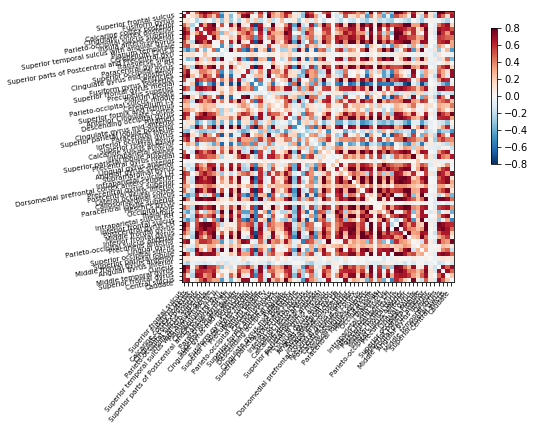

In [35]:
# Build and display a correlation matrix

# Correlation measure
correlation_matrix = ConnectivityMeasure(kind='correlation').fit_transform([time_series])[0]

# Display the correlation matrix

# Mask out the major diagonal
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix,
                     labels=labels.Difumo_names.values,
                     colorbar=True,
                     vmax=0.8,
                     vmin=-0.8)



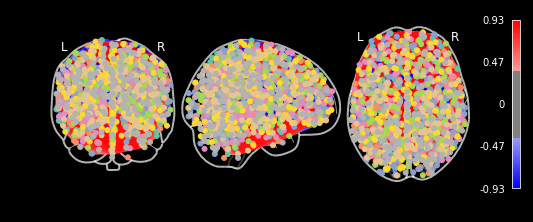

In [76]:
plotting.plot_connectome(adjacency_matrix=correlation_matrix,
                         node_coords=coords,
                         node_color='auto',
                         node_size=25,
        #                 edge_cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f54c6d8dbe0>,
                         edge_vmin=None, edge_vmax=None, edge_threshold='80%',
                         output_file=None,
                         display_mode='ortho', figure=None, axes=None,
                         title=None, annotate=True, black_bg=True,
                         alpha=0.9,
                         colorbar=True)
plotting.show()

/home/fnadeau/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


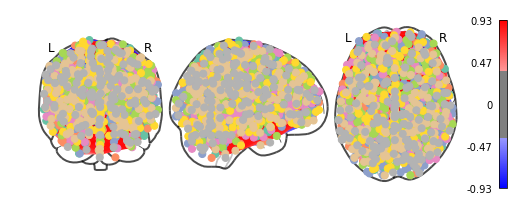

In [74]:
coords = atlas_region_coords

# We threshold to keep only the 20% of edges with the highest value
# because the graph is very dense
plotting.plot_connectome(correlation_matrix,
                         coords,
                         edge_threshold="80%", colorbar=True)

plotting.show()

In [ ]:
view = plotting.view_connectome(correlation_matrix, coords, edge_threshold='80%')

# In a Jupyter notebook, if ``view`` is the output of a cell, it will
# be displayed below the cell
view

[(<nibabel.nifti1.Nifti1Image at 0x7f54b5b03ef0>,
  <nilearn.plotting.displays.OrthoProjector at 0x7f54b2e57cc0>),
 (<nibabel.nifti1.Nifti1Image at 0x7f54b5b03f98>,
  <nilearn.plotting.displays.OrthoProjector at 0x7f557358c160>),
 (<nibabel.nifti1.Nifti1Image at 0x7f54b7e1a208>,
  <nilearn.plotting.displays.OrthoProjector at 0x7f5573271588>),
 (<nibabel.nifti1.Nifti1Image at 0x7f54b5b5ac18>,
  <nilearn.plotting.displays.OrthoProjector at 0x7f5572c4f9b0>),
 (<nibabel.nifti1.Nifti1Image at 0x7f54b5b5a9b0>,
  <nilearn.plotting.displays.OrthoProjector at 0x7f557265add8>),
 (<nibabel.nifti1.Nifti1Image at 0x7f54b5b03588>,
  <nilearn.plotting.displays.OrthoProjector at 0x7f5571db8198>)]

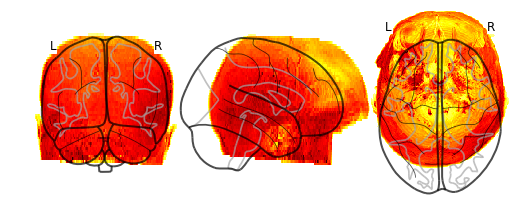

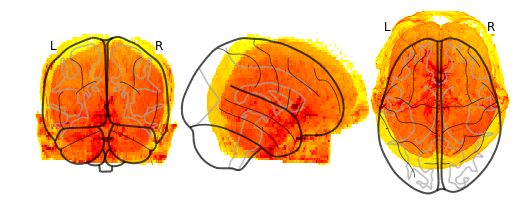

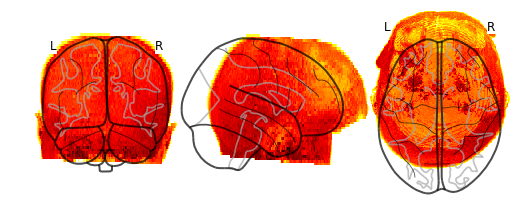

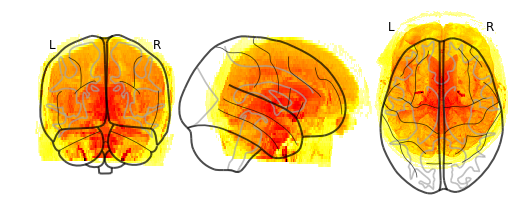

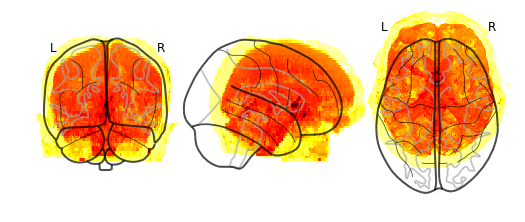

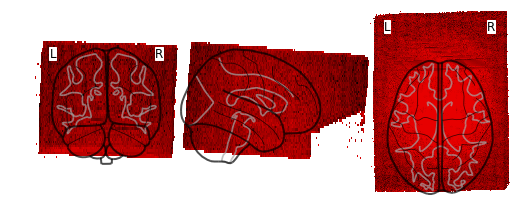

In [47]:
[(brain, plotting.plot_glass_brain(brain))
 for brain in resampled]

In [16]:
def get_mean_anat(images):
    for image in enumerate(images):
        nilearn.image.resample_to_img(source_img=image,
                                      target_img,
                                      interpolation='continuous',
                                      copy=True,
                                      order='F',
                                      clip=False,
                                      fill_value=0,
                                      force_resample=False)

SyntaxError: positional argument follows keyword argument (<ipython-input-16-77cb17c70025>, line 4)

In [12]:
maskpaths = df(tuple((img, pjoin(cimaq_path,
                                 subs.iloc[0].sub_ids,
                                 subs.iloc[0].visits,
                                 'anat', img))
                     for img in subs.iloc[0].anat
                     if '.nii' in img),
               columns = ['scan_names', 'scan_paths'])

maskpaths['to_resample'] = [[scan for scan in
                             maskpaths.scan_paths
                             if bname(scan) not in row[1].scan_paths]
                            for row in maskpaths.iterrows()]
# maskpaths.iloc[0].to_resample, maskpaths.iloc[0].scan_names
maskpaths['to_resample'].values

array([list(['/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_PD.nii.gz', '/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_T1w.nii.gz', '/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_T2star.nii.gz', '/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_T2w.nii.gz', '/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_mod-T1w_defacemask.nii.gz']),
       list(['/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_FLAIR.nii.gz', '/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_T1w.nii.gz', '/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/sub-3025432_ses-V03_T2star.nii.gz', '/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/anat/su

In [13]:
maskpaths_func = df(tuple((img, pjoin(cimaq_path,
                                 subs.iloc[0].sub_ids,
                                 subs.iloc[0].visits,
                                 'func', img))
                     for img in subs.iloc[0].func
                     if '.nii' in img),
               columns = ['scan_names_func', 'scan_paths'])

maskpaths_func['to_reseample_func'] = [[scan for scan in
                             maskpaths_func.scan_paths
                             if bname(scan) not in row[1].scan_paths]
                            for row in maskpaths_func.iterrows()]
# maskpaths_func.iloc[0].to_reseample_func, maskpaths_func.iloc[0].scan_names_func
maskpaths_func['to_reseample_func'].values



array([list(['/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/func/sub-3025432_ses-V03_task-rest_bold.nii.gz']),
       list(['/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/func/sub-3025432_ses-V03_task-memory_bold.nii.gz'])],
      dtype=object)

In [14]:
plotting.plot_glass_brain('/home/fnadeau/../../data/cisl/DATA/cimaq_20190901/sub-3025432/ses-V03/func/sub-3025432_ses-V03_task-rest_bold.nii.gz')

DimensionError: Input data has incompatible dimensionality: Expected dimension is 3D and you provided a 4D image. See http://nilearn.github.io/manipulating_images/input_output.html.

In [6]:
time_series

NameError: name 'time_series' is not defined

In [77]:
def get_fulltarcontents(mytar):
    return pd.concat([df.from_dict(tarmember.get_info(),
                                   orient='index').T
                              for tarmember in
                              mytar.getmembers()]).sort_values(
                        'name').reset_index(drop = True).iloc[1:220,:]

In [78]:
def get_series_uids(mytar):
    return pd.concat([df.from_dict(tarmember.get_info(),
                                   orient='index').T
                              for tarmember in
                              mytar.getmembers()]).sort_values(
                        'name').reset_index(drop = True).iloc[-1,:]['name']

In [4]:
## getting clean credentials

# name, value = datalad_config_path.read_text().splitlines()
# newname=name.replace(']', '').replace(
#             '[', '').replace('"', '').replace(' ', '_')
# newvalue = value[value.find('= ')+2:]
# datalad_credentials = ast.literal_eval(''.join(['{"', str(newname),
#                           '"', ' : "', newvalue, '"}']))
# with open(xpu('~/Documents/datalad_credentials.json'), 'w') as jfile:
#     json.dump(fp=jfile,
#               obj=datalad_credentials)
# jfile.close()


In [5]:
# extractedpath = '~/mytar_extracted/cimaq_dicoms_20190901/'
# seriesuids_test = next((pjoin(extractedpath, itm)
#                         for itm in ls(extractedpath)))

# series_uids = pd.read_csv(StringIO(Path(
#                     seriesuids_test).read_text()),
#                           sep = '\t')

# series_uids

In [6]:
# series_uids_pscid = df(tuple(((str(grp), str(series_uids.groupby('PSCID').get_group(
#                                 grp)['CandID'].unique().tolist()[0])),
#                               series_uids.groupby('PSCID').get_group(grp).iloc[:, 2:])
#                              for grp in series_uids.groupby('PSCID').groups))
# series_uids_pscid

In [9]:
# series_uids_pscid.to_csv('~/series_uids_pscid.tsv',
#                          sep = '\t',
#                          encoding = 'UTF-8')

In [84]:
# series_uids.to_csv('~/series_uids.tsv',
#                    sep = '\t',
#                    encoding = 'UTF-8')

sourcedata_path=Path(pjoin(dname(dname(datalad_config_path)),
                'sourcedata/cimaq_dicoms_20190901_v3.tar.gz'))

mytar=tarfile.open(sourcedata_path)

tarfile_contents = get_fulltarcontents(mytar)

tarfile_contents['names'] = [str(aname) for aname in
                             tarfile_contents.name]
tarfile_contents['basenames'] = [bname(name).strip() for name
                                 in tarfile_contents.names]
tarfile_contents['split_basenames'] = [dict(tuple(zip(('dates', 'archv_names'),
                                                 name.split('_')[1:])))
                                       for name in tarfile_contents.basenames]

# tarfile_contents.to_csv('~/tarfile_contents.tsv',
#                         sep = '\t',
#                         encoding = 'UTF-8')

In [140]:
tarfile_contents['split_basenames']
